# Image Recogniser Model

# 1. Overview:

#### 1.1 Team:
- Emma
- Raphael

#### 1.2 Topic:
**Garbage Image Classification**
##### 1.2.1 Objective:
- Build model to classify different types of garbage (recycable, non-recycable) 
    - MVP: linear classifier, SVM, DF or pretrained CNN
    - next level: self trained CNN
- Dive into CNN
- optional: create APP

##### 1.2.2 Data:
Collected by Gary Thung and Mindy Yang.
The Dataset contains 2527 images of six classes of garbage deployed on plain background:
 - 501 glass
 - 594 paper
 - 403 cardboard
 - 482 plastic
 - 410 metal
 - 137 trash


##### 1.2.3 Link to the Dataset:
https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip


## 2. Import libraries <a name="2"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import pytorch_lightning
from tqdm import trange, tqdm
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 3. Load data <a name="3"></a>
[↑ back to top ↑](#index)

#### 3.1 Load, transform and split the data:

In [ ]:
data_transformer = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
#                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])

In [117]:
def get_80_20_split(data_set):
    
    set80 = int(0.8 * len(data_set))
    set20 = len(data_set) - set80
    
    return [set80, set20] 

In [118]:
data_set = datasets.ImageFolder(root='data/dataset-resized', transform=data_transformer)

train_set, test_set = torch.utils.data.random_split(data_set, get_80_20_split(data_set))
train_set, val_set = torch.utils.data.random_split(train_set, get_80_20_split(train_set))

loader_train = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
loader_val = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

classes = data_set.classes


#### 3.2 Visualise transformed images

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(loader_val))

labels:  ['cardboard', 'metal', 'plastic', 'glass', 'metal', 'metal', 'plastic', 'glass', 'paper', 'paper', 'metal', 'plastic', 'metal', 'glass', 'metal', 'plastic', 'glass', 'metal', 'glass', 'glass', 'plastic', 'metal', 'glass', 'glass', 'paper', 'metal', 'cardboard', 'glass', 'paper', 'paper', 'metal', 'metal']


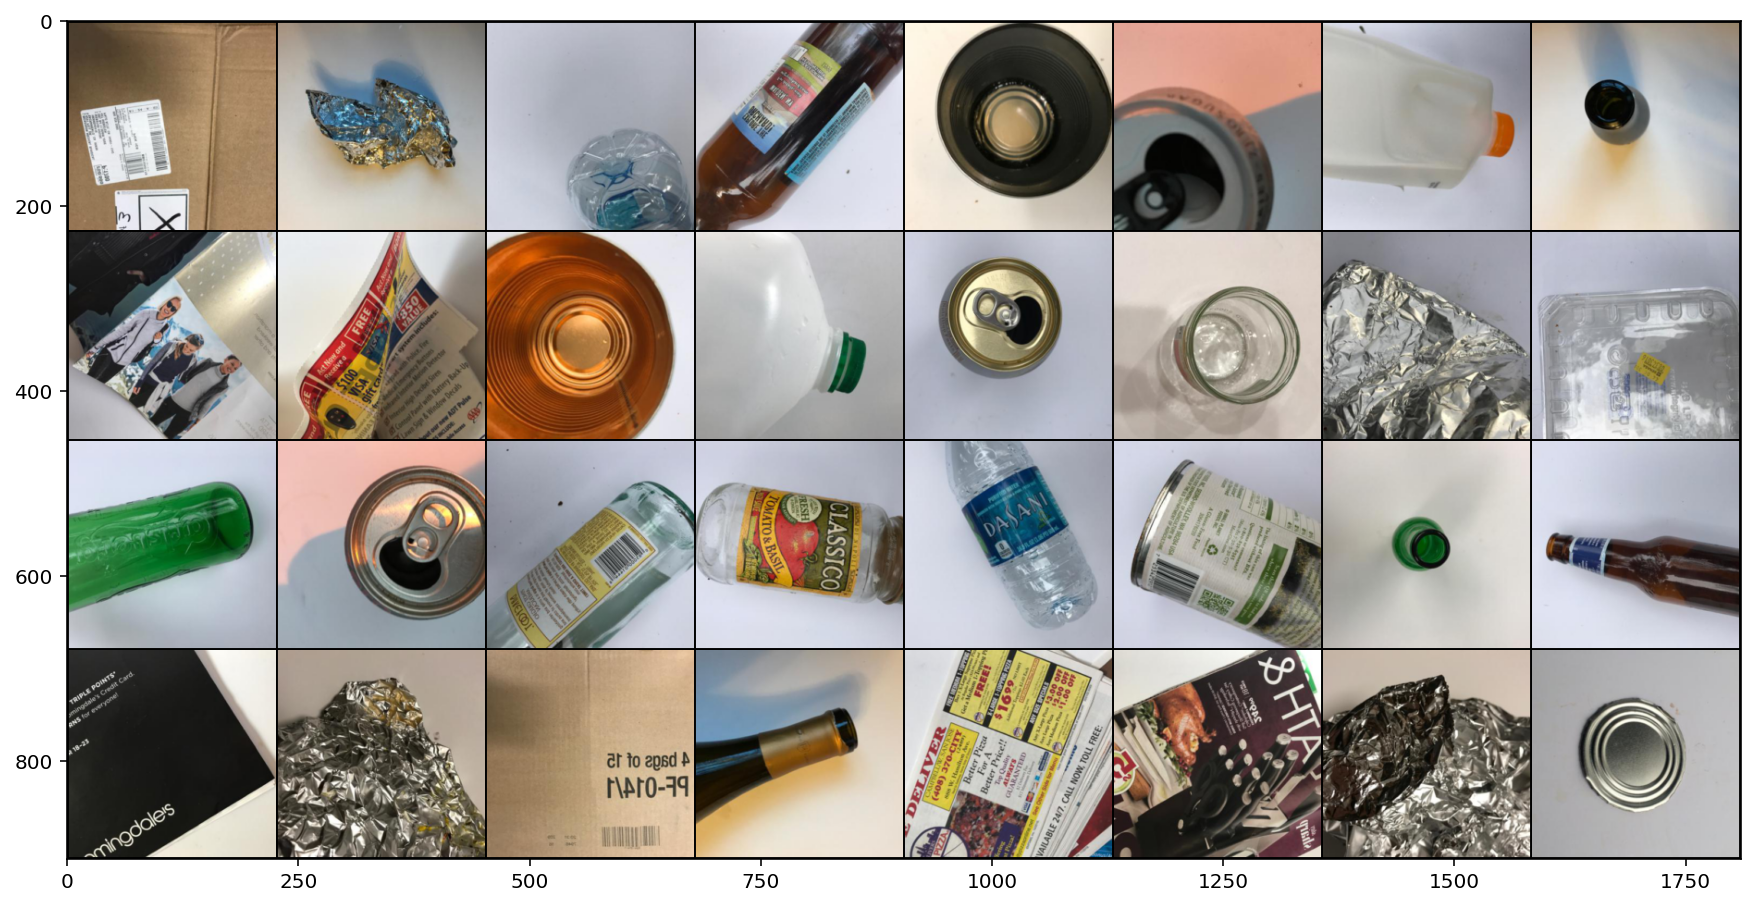

In [8]:
grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels: ', [classes[x] for x in labels])

## 4. Create model <a name="4"></a>
[↑ back to top ↑](#index)

In [9]:
try:
    with open('model/resnet18.pickle','rb') as fp:
        model = pickle.load(fp)
except:
    model = models.resnet18(pretrained=True)

## 5. Train model <a name="5"></a>
Improve the pretrained model using our own data set.
[↑ back to top ↑](#index)

In [10]:
# set tuning parameters
learn_rate = 1e-3
epochs = 0

In [11]:
optimiser = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [12]:
def training_loop(loader_train, loader_val, model, optimiser):
    
    total_loss = 0
    
    for batch, (images, labels) in enumerate(loader_train):
        
        model.train()

        pred = model(images)
        loss = nn.functional.cross_entropy(pred, labels)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        with torch.no_grad():
            
            model.eval()
            val_pred = model(images)
            val_loss = nn.functional.cross_entropy(val_pred, labels)

        print(f"Batch {batch + 1} training loss: {loss} validation loss: {val_loss}") 

        total_loss += loss.item()
    
    print(f"Accumulated loss: {total_loss}") 

    return 
    

In [13]:
for i in trange(epochs):
    
    print()
    print(f"Epoch {i+1}\n------------------------")
    training_loop(loader_train, loader_val, model, optimiser)
    

0it [00:00, ?it/s]


In [14]:
with open('model/resnet18.pickle','wb') as fp:
    pickle.dump(model, fp)

## 6. Visualise model predictions <a name="6"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)

In [113]:
loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
images, labels = next(iter(loader))
print(labels)

tensor([4])


plastic


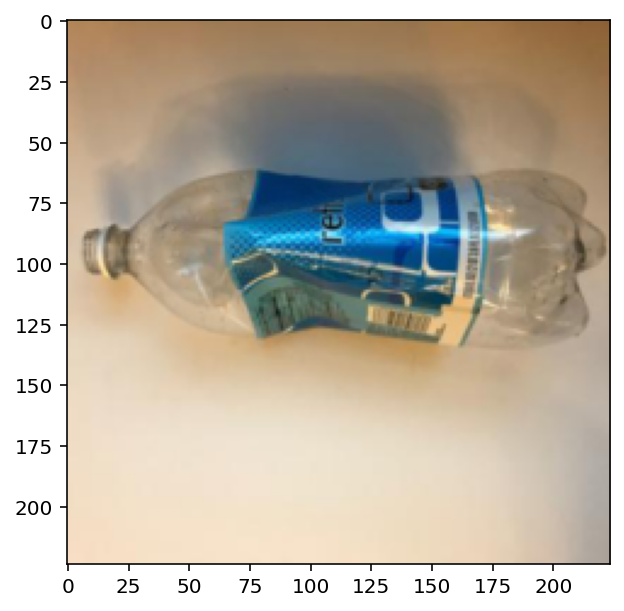

In [114]:
grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(classes[int(labels)])


In [123]:
with torch.no_grad():
    
    images_pred = model(images)
    pred_label = np.argmax(images_pred)
    prob = torch.softmax(images_pred, dim=1)
    
    for i in range(6):
        
        print(classes[i], round(float(prob[0][i])*100, 2), "%")
        

cardboard 2.36 %
glass 4.97 %
metal 0.29 %
paper 0.75 %
plastic 87.34 %
trash 0.97 %


In [76]:
import os
from torch.utils.data import Dataset
import natsort
from IPython.display import Image

from torchvision.io import read_image

In [109]:
class CustomDataSet(Dataset):
#     def __init__(self, main_dir, transform):
#         self.main_dir = main_dir
#         self.transform = transform
#         all_imgs = os.listdir(main_dir)
#         self.total_imgs = natsort.natsorted(all_imgs)
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        all_imgs = os.listdir(img_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        try:
            if from_memory:
                img = Image.open(img_loc)
                res = img.convert('RGB')
            else:
                with open(img_loc, 'rb') as f:
                    img = Image.open(f)
                    res = img.convert('RGB')
        except:
            res = Image.new('RGB', (227, 227), color=0)
        return res
    
      #  image = Image.open(img_loc).convert("RGB")
#         image = read_image(img_loc)
#        image = self.transform()

        tensor_image = self.transform(res)
        return tensor_image

In [110]:
my_dataset = CustomDataSet('data/test_images', transform=data_transformer)
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, shuffle=False, drop_last=True)

#test_loader = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False, 
                               #num_workers=4, drop_last=True)

In [111]:
def image_classifier(test_loader):
    
    
    for batch, images in enumerate(test_loader):
        
        grid = torchvision.utils.make_grid(images, nrow=8)

        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
     #   print(classes[int(labels)])
    
    print(f"Accumulated loss: {total_loss}") 

    return 
    

In [112]:
image_classifier(test_loader)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
image_classifier('bottle.jpg')

In [89]:
from PIL import Image


In [92]:
def safe_pil_loader(path, from_memory=False):
    try:
        if from_memory:
            img = Image.open(path)
            res = img.convert('RGB')
        else:
            with open(path, 'rb') as f:
                img = Image.open(f)
                res = img.convert('RGB')
    except:
        res = Image.new('RGB', (227, 227), color=0)
    return res

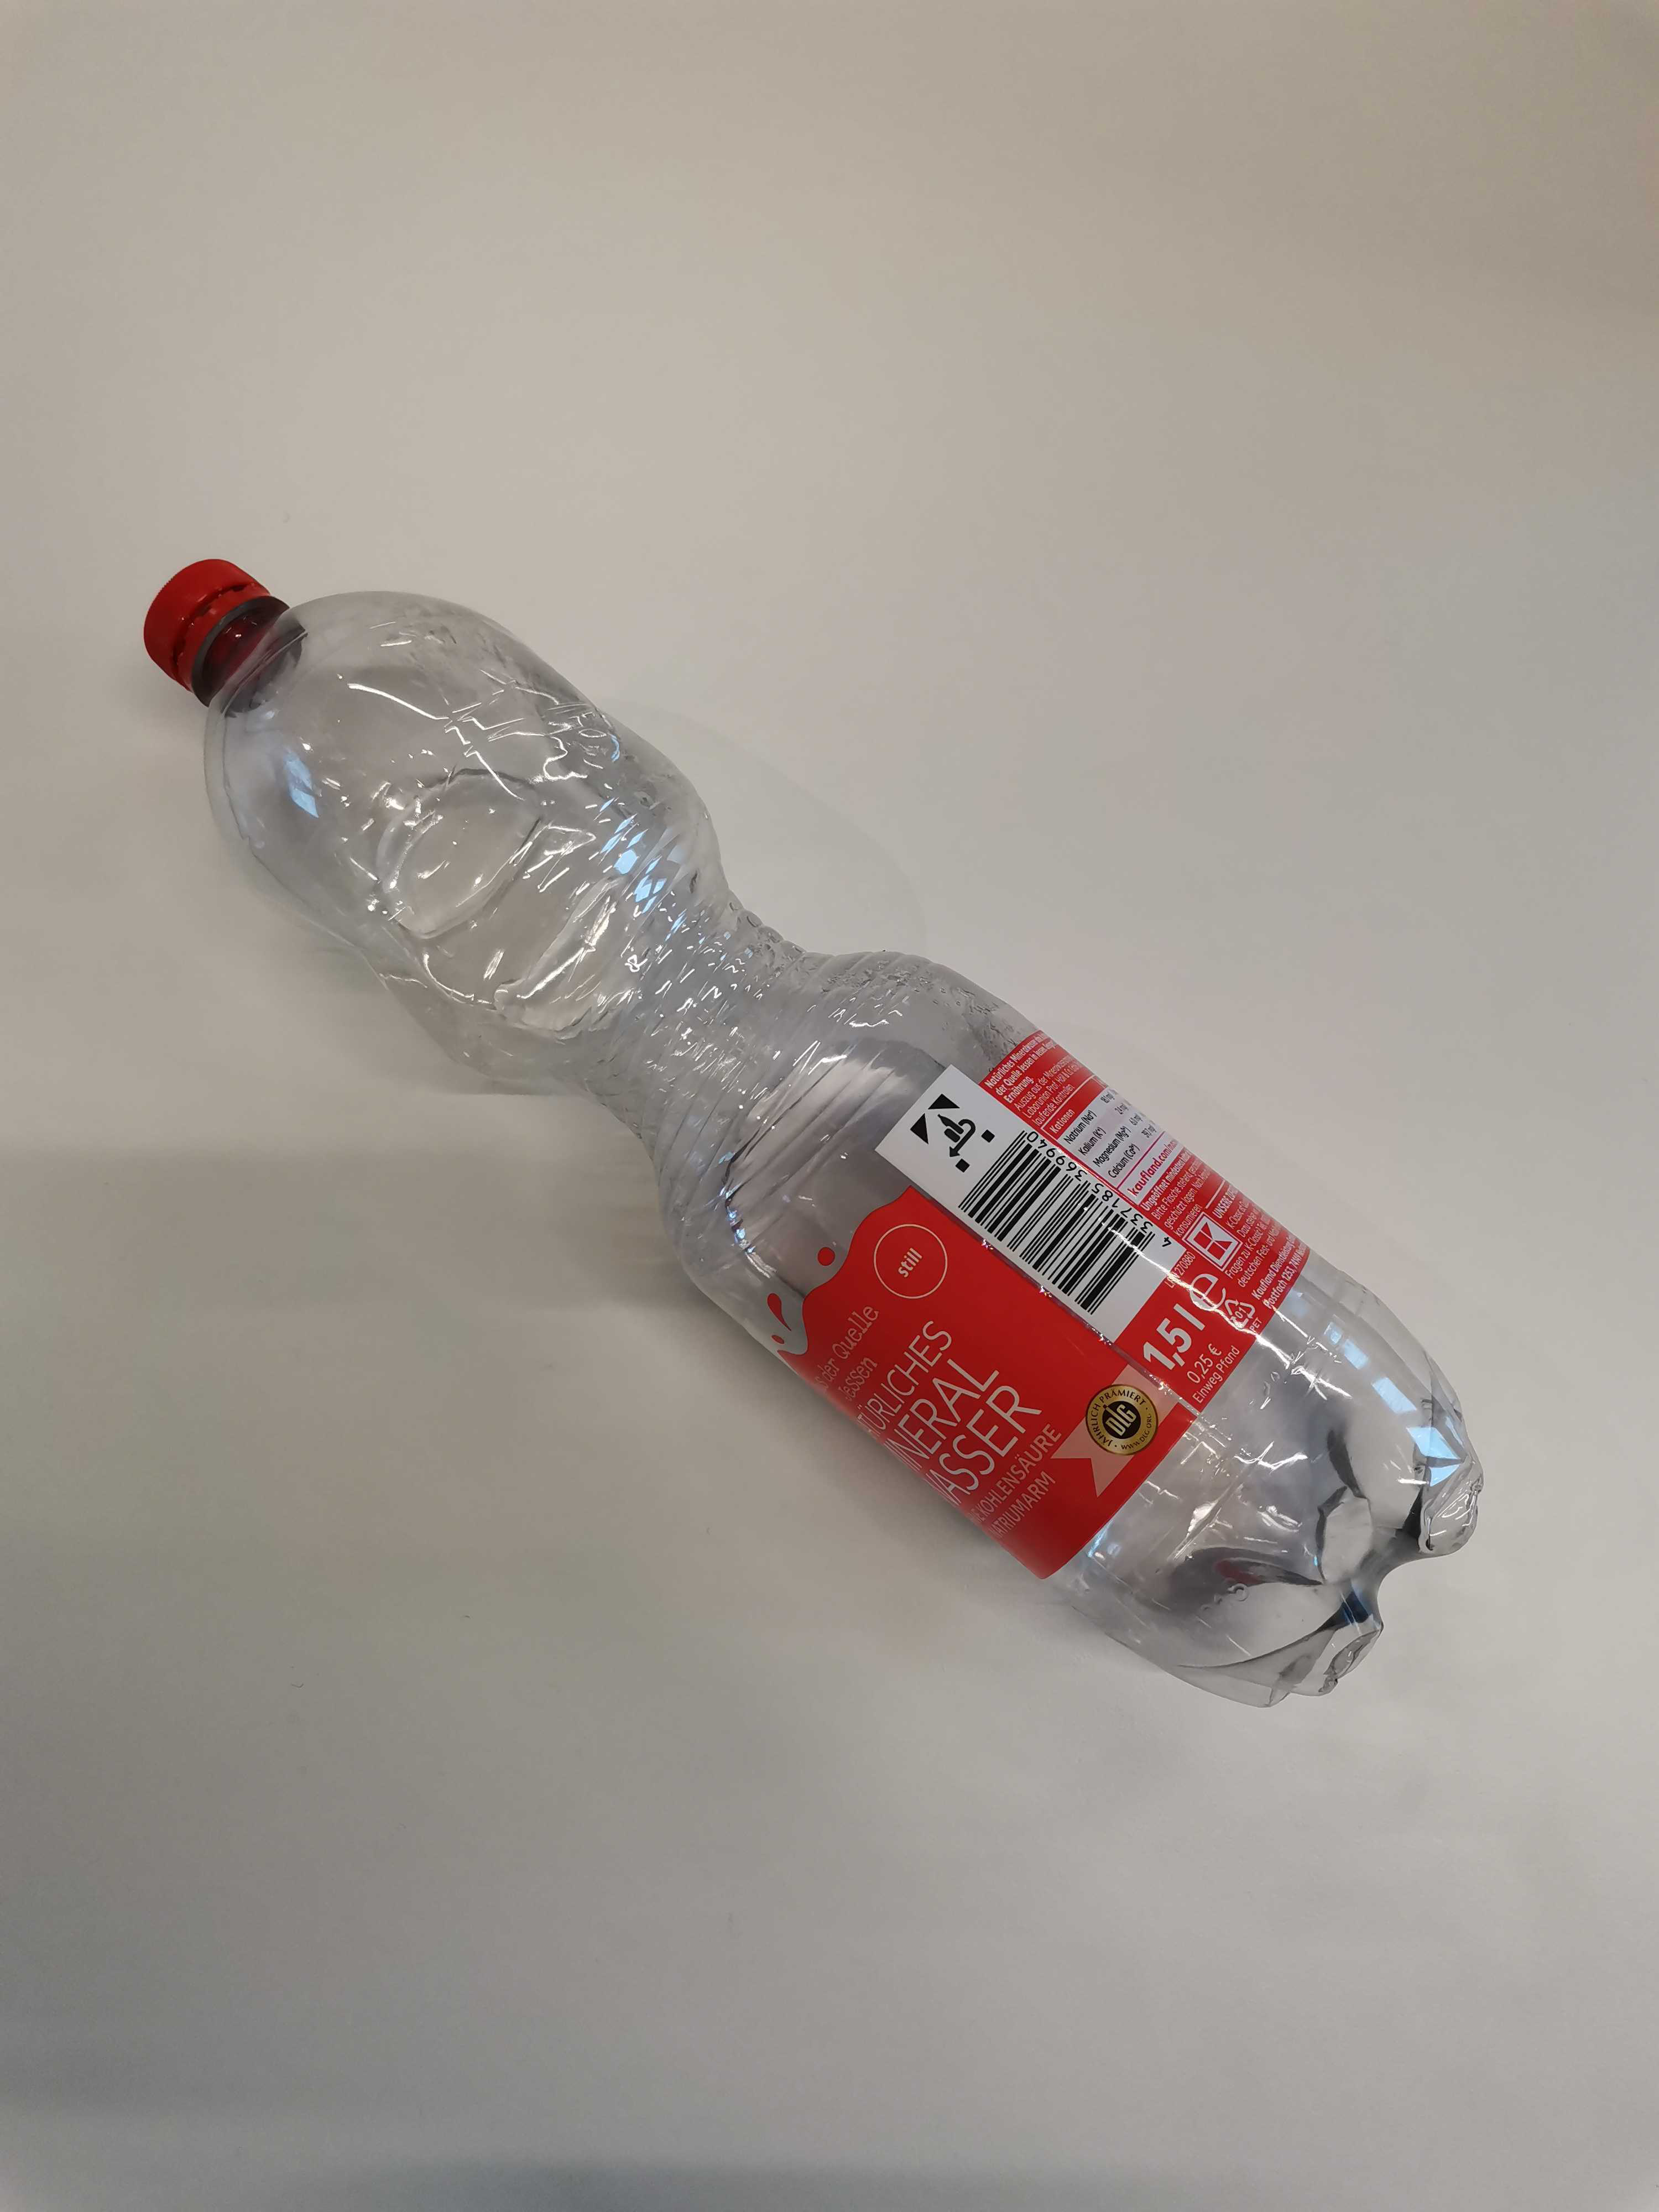

In [93]:
safe_pil_loader("data/test_images/bottle.jpg")

## 7. Tune parameters <a name="7"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)

## 8. Execute and evaluate <a name="8"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)

## 9. Create predictor function<a name="9"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)